# Notebook 2: Scenario Model + Q Distribution (30D)

## 1. Define tariff shock scenarios  
## 2. Calibrate baseline drift and volatility from SMH history  
## 3. Simulate scenario-weighted terminal price distribution  
## 4. Visualise quantiles + histogram

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Project root added:", PROJECT_ROOT)


Project root added: c:\Users\nicho\tariff-options-strategy


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from src.tariff_strategy.data.market_data import fetch_price_history
from src.tariff_strategy.modeling.scenarios import tariff_scenarios
from src.tariff_strategy.modeling.calibration import baseline_mu_30d, baseline_sigma_30d
from src.tariff_strategy.modeling.distribution import simulate_terminal_prices


In [3]:
TICKER = "SMH"

prices = fetch_price_history(TICKER, period="2y")

last = prices["Adj Close"].iloc[-1]
s0 = float(last.iloc[0]) if hasattr(last, "iloc") else float(last)

print(f"S0 (latest Adj Close): {s0:.2f}")


S0 (latest Adj Close): 400.39


In [4]:
scen = tariff_scenarios()
scen


,scenario,p,severity
0,No new measures,0.45,0
1,Mild tariffs / tighter language,0.30,1
2,Aggressive tariffs / restrictions,0.20,2
3,Aggressive + retaliation,0.05,3


In [5]:
mu_base = baseline_mu_30d(prices, window=30, trim=0.10)
sigma_base = baseline_sigma_30d(prices, window=30)

print(f"Calibrated baseline mu_30:    {mu_base:.4f}")
print(f"Calibrated baseline sigma_30: {sigma_base:.4f}")


Calibrated baseline mu_30:    0.0447
Calibrated baseline sigma_30: 0.1075


In [6]:
N_SIMS = 50_000

sims = simulate_terminal_prices(
    s0=s0,
    scenarios=scen,
    mu_base=mu_base,
    sigma_base=sigma_base,
    n_sims=N_SIMS,
    seed=42
)

sims.head()


,scenario,p,severity,log_return,S_T
0,Aggressive tariffs / restrictions,0.20,2,-0.000403,400.228876
1,No new measures,0.45,0,0.049844,420.852953
2,Aggressive tariffs / restrictions,0.20,2,0.220576,499.204034
3,Mild tariffs / tighter language,0.30,1,0.080861,434.110841
4,No new measures,0.45,0,-0.047032,381.994930


In [7]:
quantiles = sims["S_T"].quantile([0.01, 0.05, 0.50, 0.95, 0.99])
quantiles


0.01    285.462057
0.05    326.445118
0.50    413.622945
0.95    512.721988
0.99    567.787630
Name: S_T, dtype: float64

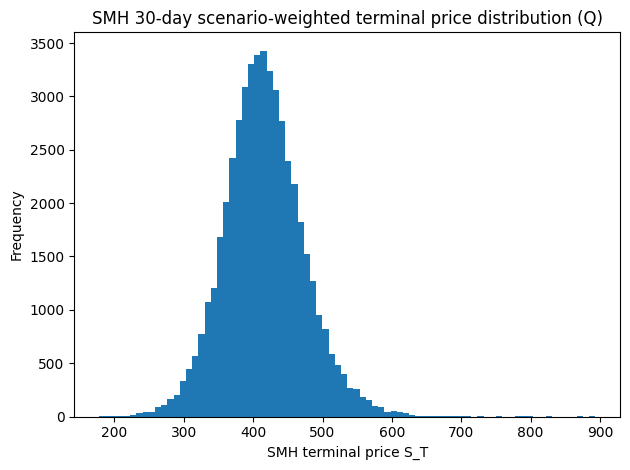

In [8]:
plt.figure()
plt.hist(sims["S_T"], bins=80)
plt.title("SMH 30-day scenario-weighted terminal price distribution (Q)")
plt.xlabel("SMH terminal price S_T")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

sims.to_csv(DATA_DIR / "notebook2_smh_terminal_distribution.csv", index=False)

print("Saved:", DATA_DIR / "notebook2_smh_terminal_distribution.csv")


Saved: data\notebook2_smh_terminal_distribution.csv
